In [189]:
## Should have all the same signal processing functions from the signal package in R:
## https://cran.r-project.org/web/packages/signal/signal.pdf
from scipy.signal import butter, lfilter

## https://docs.scipy.org/doc/scipy/reference/signal.html

import pandas as pd
import numpy as np
import csv
import glob
import json
import re
import matplotlib.pyplot as plt
from datetime import datetime

Define a helper function to convert from the unix timestamp to UTC:

In [200]:
def get_utc_date_time(ts):
    return datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')

Found some code on stack overflow and in SciPy's community website that implements a band pass butterworth filter for a 1d array: https://scipy-cookbook.readthedocs.io/items/ButterworthBandpass.html#.  I dont know what order filter we need for this data, but for exploratory data analysis, it appears to work ok

In [299]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

## May need to better understand which order filter is needed for this dataset
def butter_bandpass_filter(data, lowcut, highcut, fs, column_name, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    y = pd.DataFrame(y, columns=[column_name])
    return y

Take all the CSV files in the test data folder and concatenate them together.

For this exploratory analysis, we would like to plot against timepoints.  The data supplied for each EDA is in 1 column (including the original timestamp), so we must transpose the data frame so that each column becomes 1 row in the eventual dataset.  

Ie, 1 column with 8k rows becomes 8k columns (representing timepoints) with 1 row (representing the entire run)

In [300]:
file_path = r'/Users/dancohen/Code_Projects/Empatica E4 Analysis/EDA_Test_data'
all_files = glob.glob(file_path + "/*.csv")

In [301]:
fs = 4.0 ## Sampling frequency.  This test data was gathered at 4hz
lowcut = 0.05 ## Lower bound for the filter, as directed by Empatica documentation
highcut = 1.0  ## Upper bound for the filter, as directed by Empatica documentation

In [302]:
unfiltered_EDA = []
filtered_EDA = []

for file_path in all_files:
    path = file_path.split('/')

    #Grabs the 3 digit pariticipant code in the test file names
    csv = path[len(path)-1]
    file_code = csv[5:7]
    df = pd.read_csv(file_path, header=None)
    # For this test data, we dont care about the first row, which is the timestamp. 
    # We didnt import the csv with a header, so the column header is '0'.  Just rename that to the participant ID
    # NOTE: The sampling rate of 4hz is found in the second row of each csv file, so we just drop that row as well
    # https://support.empatica.com/hc/en-us/articles/201608896-Data-export-and-formatting-from-E4-connect-
    
    df = df.rename(columns={0: file_code}).drop(df.index[0:3])
    unfiltered_EDA.append(df.transpose())
    filtered_EDA.append(butter_bandpass_filter(df[file_code], lowcut, highcut, fs, file_code).transpose())
    
untiltered_frame = pd.concat(unfiltered_EDA)
filtered_frame = pd.concat(filtered_EDA)

We are transposing the entire dataframe back into 4 columns and ~8k rows just to make doing simple graphs easier.  Turns out that using matplotlib's plot.show() by default looks at each column as a line in the plot

In [303]:
filtered_frame = filtered_frame.transpose()
untiltered_frame = untiltered_frame.transpose()

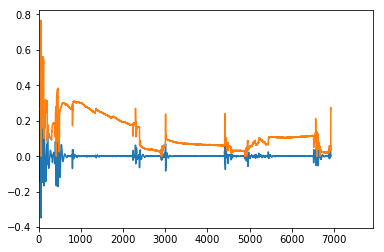

In [304]:
filtered_frame['05'].plot()
untiltered_frame['05'].plot()
plt.show()